In [39]:
 from skimage.io import imshow, imread
 from skimage.color import rgb2gray
 from skimage.filters import threshold_otsu
 from skimage.morphology import closing
 from skimage.measure import label, regionprops, regionprops_table
 from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
 from sklearn.model_selection import train_test_split
 from sklearn.metrics import classification_report
 from matplotlib import pyplot as plt
 import pandas as pd
 import numpy as np
 from tqdm import tqdm 
 import os
 import seaborn as sns

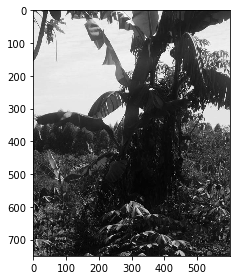

In [14]:
 # get the filenames of the leaves under the directory bananas_cropped
 image_path_list = os.listdir("bananas_cropped")
 # look at the first image
 i = 0
 image_path = image_path_list[i]
 image = rgb2gray(imread("bananas_cropped/"+image_path))
 imshow((image))

preprocess the image by binarizing it first using Otsu’s method and cleaned it using the closing morphological operation

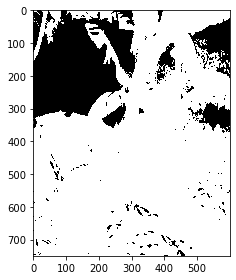

In [15]:
binary = image < threshold_otsu(image)
binary = closing(binary)
imshow(binary)

label the preprocessed image in preparation for feature extraction.

c:\Users\DELL\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


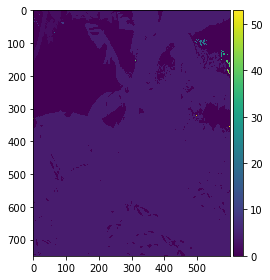

In [16]:
label_img = label(binary)
imshow(label_img)

Extract features from all images and store it in a dataframe

In [17]:
image_path_list = os.listdir("bananas_cropped")
data_set = pd.DataFrame()
for i in range(len(image_path_list)):
   
  image_path = image_path_list[i]
  image = rgb2gray(imread("bananas_cropped/"+image_path))
  binary = image < threshold_otsu(image)
  binary = closing(binary)
  label_img = label(binary)
  
  data_table = pd.DataFrame(regionprops_table(label_img, image,
                                       ['convex_area', 'area',
                                        'eccentricity', 'extent', 'image' ,                 
                                        'inertia_tensor','perimeter',
                                        'major_axis_length', 
                                        'minor_axis_length','solidity','orientation',
                                        'moments_central',
                                        'moments_hu',
                                        'euler_number',
                                        'equivalent_diameter',
                                        'mean_intensity',
                                        'bbox']))
  data_table['perimeter_area_ratio'] = data_table['perimeter']/data_table['area']
  real_images = []
  std = []
  mean = []
  percent25 = []
  percent75 = []
  for prop in regionprops(label_img): 
      
      min_row, min_col, max_row, max_col = prop.bbox
      img = image[min_row:max_row,min_col:max_col]
      real_images += [img]
      mean += [np.mean(img)]
      std += [np.std(img)]
      percent25 += [np.percentile(img, 25)] 
      percent75 += [np.percentile(img, 75)]
  data_table['real_images'] = real_images
  data_table['mean_intensity'] = mean
  data_table['std_intensity'] = std
  data_table['25th Percentile'] = mean
  data_table['75th Percentile'] = std
  data_table['iqr'] = data_table['75th Percentile'] - data_table['25th Percentile']
  data_table['label'] = image_path[0:14]
  data_set = pd.concat([data_set, data_table], axis=0)
data_set.head()

,convex_area,area,eccentricity,extent,image,inertia_tensor-0-0,inertia_tensor-0-1,inertia_tensor-1-0,inertia_tensor-1-1,perimeter,...,bbox-1,bbox-2,bbox-3,perimeter_area_ratio,real_images,std_intensity,25th Percentile,75th Percentile,iqr,label
0,100,67,0.928480,0.348958,"[[True, True, True, True, True, True, True, Tr...",14.409000,-7.719091,-7.719091,7.772332,39.142136,...,2,12,18,0.584211,"[[0.3216133333333333, 0.5529858823529412, 0.32...",0.260829,0.676630,0.260829,-0.415801,Bananas_1.jpg
1,8181,4506,0.939233,0.309989,"[[False, False, False, False, False, False, Fa...",472.742618,583.990368,583.990368,1489.599426,815.387914,...,0,158,92,0.180956,"[[0.9412211764705882, 0.6235741176470588, 0.32...",0.274357,0.698523,0.274357,-0.424167,Bananas_1.jpg
2,5286,3533,0.978431,0.526685,"[[False, False, False, False, True, True, True...",1761.567844,-88.883829,-88.883829,80.055719,631.043723,...,101,43,257,0.178614,"[[0.919114117647059, 0.930610980392157, 0.9398...",0.268902,0.583884,0.268902,-0.314983,Bananas_1.jpg
3,416969,339640,0.677777,0.754756,"[[False, False, False, False, False, False, Fa...",26808.476013,7470.201664,7470.201664,39973.186802,11148.016767,...,0,750,600,0.032823,"[[0.9412211764705882, 0.6235741176470588, 0.32...",0.313699,0.332155,0.313699,-0.018456,Bananas_1.jpg
4,28,25,0.806743,0.714286,"[[True, True, False, True, True, False, True],...",3.510400,0.819200,0.819200,1.641600,18.071068,...,257,11,264,0.722843,"[[0.5090152941176471, 0.4776427450980392, 0.52...",0.113049,0.501020,0.113049,-0.387971,Bananas_1.jpg


define a method to assign class label to the dataset

In [18]:
def image_class (row):
   if 'Banana' in row['label'] :
      return '1'
   if 'Cassava' in row['label'] :
      return '0'
   return 2

assign the class to the dataframe

In [19]:
data_set['class_label'] = data_set.apply (lambda row: image_class(row), axis=1)

In [20]:
data_set.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56298 entries, 0 to 157
Data columns (total 52 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   convex_area           56298 non-null  int32  
 1   area                  56298 non-null  int32  
 2   eccentricity          56298 non-null  float64
 3   extent                56298 non-null  float64
 4   image                 56298 non-null  object 
 5   inertia_tensor-0-0    56298 non-null  float64
 6   inertia_tensor-0-1    56298 non-null  float64
 7   inertia_tensor-1-0    56298 non-null  float64
 8   inertia_tensor-1-1    56298 non-null  float64
 9   perimeter             56298 non-null  float64
 10  major_axis_length     56298 non-null  float64
 11  minor_axis_length     56298 non-null  float64
 12  solidity              56298 non-null  float64
 13  orientation           56298 non-null  float64
 14  moments_central-0-0   56298 non-null  float64
 15  moments_central-0-1  

In [21]:
data_set

,convex_area,area,eccentricity,extent,image,inertia_tensor-0-0,inertia_tensor-0-1,inertia_tensor-1-0,inertia_tensor-1-1,perimeter,...,bbox-2,bbox-3,perimeter_area_ratio,real_images,std_intensity,25th Percentile,75th Percentile,iqr,label,class_label
0,100,67,0.928480,0.348958,"[[True, True, True, True, True, True, True, Tr...",14.409000,-7.719091,-7.719091,7.772332,39.142136,...,12,18,0.584211,"[[0.3216133333333333, 0.5529858823529412, 0.32...",0.260829,0.676630,0.260829,-0.415801,Bananas_1.jpg,1
1,8181,4506,0.939233,0.309989,"[[False, False, False, False, False, False, Fa...",472.742618,583.990368,583.990368,1489.599426,815.387914,...,158,92,0.180956,"[[0.9412211764705882, 0.6235741176470588, 0.32...",0.274357,0.698523,0.274357,-0.424167,Bananas_1.jpg,1
2,5286,3533,0.978431,0.526685,"[[False, False, False, False, True, True, True...",1761.567844,-88.883829,-88.883829,80.055719,631.043723,...,43,257,0.178614,"[[0.919114117647059, 0.930610980392157, 0.9398...",0.268902,0.583884,0.268902,-0.314983,Bananas_1.jpg,1
3,416969,339640,0.677777,0.754756,"[[False, False, False, False, False, False, Fa...",26808.476013,7470.201664,7470.201664,39973.186802,11148.016767,...,750,600,0.032823,"[[0.9412211764705882, 0.6235741176470588, 0.32...",0.313699,0.332155,0.313699,-0.018456,Bananas_1.jpg,1
4,28,25,0.806743,0.714286,"[[True, True, False, True, True, False, True],...",3.510400,0.819200,0.819200,1.641600,18.071068,...,11,264,0.722843,"[[0.5090152941176471, 0.4776427450980392, 0.52...",0.113049,0.501020,0.113049,-0.387971,Bananas_1.jpg,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,18,16,0.775457,0.640000,"[[True, False, False, False, False], [True, Tr...",1.484375,-0.664062,-0.664062,1.621094,13.035534,...,500,601,0.814721,"[[0.28013019607843137, 0.34091098039215684, 0....",0.093541,0.301143,0.093541,-0.207602,Cassava_99.jpg,0
154,17,15,0.739444,0.750000,"[[True, True, False, False, False], [True, Tru...",1.582222,-0.440000,-0.440000,1.093333,11.621320,...,500,131,0.774755,"[[0.2107035294117647, 0.13227921568627451, 0.3...",0.165494,0.240526,0.165494,-0.075033,Cassava_99.jpg,0
155,22,17,0.897077,0.531250,"[[False, False, True, False, False, False, Fal...",3.820069,-0.519031,-0.519031,0.851211,16.071068,...,500,282,0.945357,"[[0.5364254901960784, 0.4809878431372549, 0.53...",0.123668,0.342409,0.123668,-0.218742,Cassava_99.jpg,0
156,2,2,1.000000,0.500000,"[[False, True], [True, False]]",0.250000,0.250000,0.250000,0.250000,0.000000,...,500,238,0.000000,"[[0.3285690196078431, 0.2768], [0.243745098039...",0.030672,0.286027,0.030672,-0.255355,Cassava_99.jpg,0


Check for class balance

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

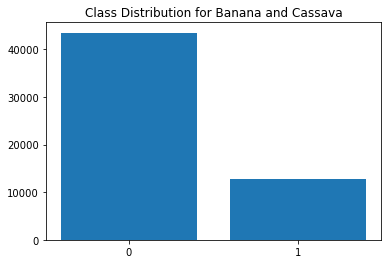

In [23]:
plt.title('Class Distribution for Banana and Cassava')
plt.bar(data_set['class_label'].value_counts().index, data_set['class_label'].value_counts().values)
plt.show()

Define X and Y values and split them

In [24]:
X = data_set.drop(columns=['label', 'image', 'real_images','class_label'])
#X=df
#features
X = X[['iqr','75th Percentile','inertia_tensor-1-1',
       'std_intensity','mean_intensity','25th Percentile',
       'minor_axis_length', 'solidity', 'eccentricity']]
#target
y = data_set['class_label']
columns = X.columns
#train-test-split
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.30, random_state=123, stratify=y)

In [25]:
# training the model on training set
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
  
# making predictions on the testing set
y_pred = gnb.predict(X_test)
  
# comparing actual response values (y_test) with predicted response values (y_pred)
from sklearn import metrics
print("Gaussian Naive Bayes model accuracy(in %):", metrics.accuracy_score(y_test, y_pred)*100)

Gaussian Naive Bayes model accuracy(in %): 96.70811130846656


In [26]:
print(y_pred)

['0' '0' '1' ... '1' '0' '0']


In [27]:
print(f"Test Accuracy: {np.mean(gnb.predict(X_test) ==y_test)*100:.2f}%")

Test Accuracy: 96.71%


In [28]:
#print confusion matrix of test set
print(classification_report(gnb.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     13355
           1       0.89      0.96      0.92      3535

    accuracy                           0.97     16890
   macro avg       0.94      0.97      0.95     16890
weighted avg       0.97      0.97      0.97     16890



Confusion Matrix for Naive Bayes Classifier

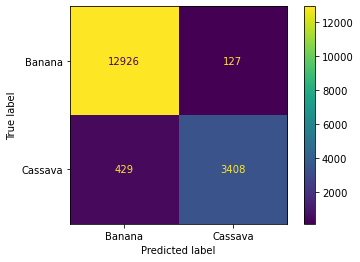

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
class_names=['Banana','Cassava']

cm=confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
disp.plot()

plt.show()

In [30]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)
#KNeighborsClassifier(...)
print(neigh.predict(X_test))




['0' '0' '1' ... '1' '0' '0']


In [31]:
print(f"Test Accuracy: {np.mean(neigh.score(X_test,y_test))*100:.2f}%")


Test Accuracy: 99.22%


Confusion Matrix for KNN Classifier

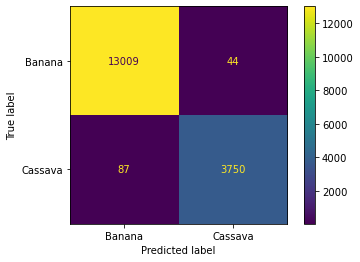

In [42]:
cm=confusion_matrix(y_test, neigh.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
disp.plot()

plt.show()

In [33]:
print(neigh.predict_proba(X_test))

[[1. 0.]
 [1. 0.]
 [0. 1.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]]


In [34]:
#print confusion matrix of test set
print(classification_report(neigh.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     13096
           1       0.98      0.99      0.98      3794

    accuracy                           0.99     16890
   macro avg       0.99      0.99      0.99     16890
weighted avg       0.99      0.99      0.99     16890



In [35]:
K = []
training = []
test = []
scores = {}
  
for k in range(2, 21):
    classifier= KNeighborsClassifier(n_neighbors = k)
    classifier.fit(X_train, y_train)
  
    train_score = classifier.score(X_train, y_train)
    test_score = classifier.score(X_test, y_test)
    
    
    K.append(k)
  
    training.append(train_score)
    test.append(test_score)
    scores[k] = [train_score, test_score]

In [36]:
for keys, values in scores.items():
	print(keys, ':', values)

2 : [0.9958130328867235, 0.992421551213736]
3 : [0.9960921640276086, 0.9922439313203079]
4 : [0.993427730410069, 0.9907045589105979]
5 : [0.994239748274462, 0.9910005920663114]
6 : [0.9926410881039383, 0.9905861456483126]
7 : [0.992793341453512, 0.9902901124925991]
8 : [0.9911185546082014, 0.9895204262877443]
9 : [0.9909409257003654, 0.9894612196566015]
10 : [0.9901035322777101, 0.9888691533451747]
11 : [0.9904080389768575, 0.988809946714032]
12 : [0.9894691433211531, 0.9885139135583185]
13 : [0.9895960211124645, 0.9884547069271759]
14 : [0.9888093788063338, 0.9873889875666074]
15 : [0.9888855054811205, 0.9876258140911782]
16 : [0.9878197320341048, 0.9870337477797513]
17 : [0.988022736500203, 0.9865600947306098]
18 : [0.9873375964271214, 0.986145648312611]
19 : [0.9872614697523345, 0.9856719952634695]
20 : [0.9863225740966302, 0.9859088217880403]


Visualization of Training scores against number of Neigbors

c:\Users\DELL\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


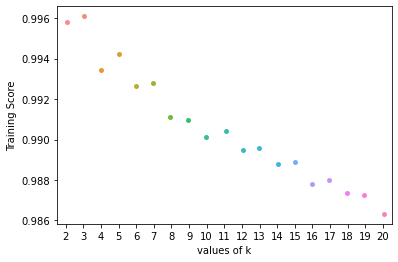

In [40]:
ax = sns.stripplot(K, training);
ax.set(xlabel ='values of k', ylabel ='Training Score')

plt.show()
# function to show plot

Visualization of Testing scores against number of Neigbors

c:\Users\DELL\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


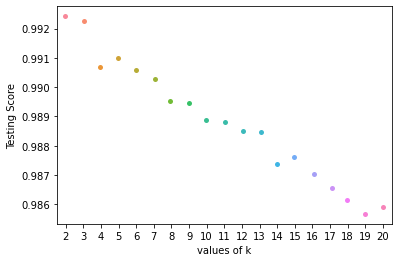

In [41]:
ax = sns.stripplot(K, test);
ax.set(xlabel ='values of k', ylabel ='Testing Score')

plt.show()
